## Parte II: Machine Learning Baseline
Bautista Boeri - 110898

Enlace a este notebook:https://colab.research.google.com/drive/1iAhI1VmR7gZyT3Ma49jTq6U7XG4naSZE?usp=sharing

In [ ]:
import pandas as pd
from google.colab import drive
!pip install category_encoders -q
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report
import xgboost as xgb


drive.mount('/content/drive')
# Load the DataFrames from pickle files
tweets_df = pd.read_pickle('/content/drive/MyDrive/tp3/tweets_engineered_features_refactored.pkl')
test_df = pd.read_pickle('/content/drive/MyDrive/tp3/test_engineered_features_refactored.pkl')

# Display the first few rows of each DataFrame
print("Tweets DataFrame:")
display(tweets_df.head())

print("\nTest DataFrame:")
display(test_df.head())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 1.9 MB/s eta 0:00:00
Mounted at /content/drive
Tweets DataFrame:


,id,keyword,location,text,target,cantidad_emoji,cantidad_hashtags,cantidad_arrobas,sentimiento,cantidad_links,tiene_4_simbolos_consecutivos,cantidad_palabras
0,1,sin_keyword,sin_locacion,Our Deeds are the Reason of this #earthquake M...,1,0,1,0,positivo,0,0,13
1,4,sin_keyword,sin_locacion,Forest fire near La Ronge Sask. Canada,1,0,0,0,negativo,0,0,7
2,5,sin_keyword,sin_locacion,All residents asked to 'shelter in place' are ...,1,0,0,0,negativo,0,0,22
3,6,sin_keyword,sin_locacion,"13,000 people receive #wildfires evacuation or...",1,0,1,0,positivo,0,0,8
4,7,sin_keyword,sin_locacion,Just got sent this photo from Ruby #Alaska as ...,1,0,2,0,positivo,0,0,16



Test DataFrame:


,id,keyword,location,text,cantidad_emoji,cantidad_hashtags,cantidad_arrobas,sentimiento,cantidad_links,tiene_4_simbolos_consecutivos,cantidad_palabras
0,0,sin_keyword,sin_locacion,Just happened a terrible car crash,0,0,0,muy negativo,0,0,6
1,2,sin_keyword,sin_locacion,"Heard about #earthquake is different cities, s...",0,1,0,positivo,0,0,9
2,3,sin_keyword,sin_locacion,"there is a forest fire at spot pond, geese are...",0,0,0,muy negativo,0,0,19
3,9,sin_keyword,sin_locacion,Apocalypse lighting. #Spokane #wildfires,0,2,0,positivo,0,0,4
4,11,sin_keyword,sin_locacion,Typhoon Soudelor kills 28 in China and Taiwan,0,0,0,muy negativo,0,0,8


Rellenamos los nans

In [ ]:
tweets_df['keyword'] = tweets_df['keyword'].fillna('sin_keyword')
tweets_df['location'] = tweets_df['location'].fillna('sin_locacion')

test_df['keyword'] = test_df['keyword'].fillna('sin_keyword')
test_df['location'] = test_df['location'].fillna('sin_locacion')

Separamos los features en base a encoding correspondientes

In [ ]:
text_features = 'text'

# Features binarias (se mantienen igual)
binary_features = [ 'tiene_4_simbolos_consecutivos']

# Features numéricas (conteos refactorizados)
numeric_features = ['cantidad_emoji', 'cantidad_hashtags', 'cantidad_arrobas', 'cantidad_links', 'cantidad_palabras']

# Features categóricas
onehot_features = ['sentimiento']
binary_encode_features = ['keyword']
mean_encode_features = ['location']

# Todas las features
feature_cols = [text_features] + numeric_features + onehot_features + mean_encode_features + binary_features + binary_encode_features

Separamos el dataset de los tweets para poder validarlo. Usamos la estrategia para asegurarnos que el set de validacion y de entrenamiento esten balanceados entre si. De esta forma, nos aseguramos que tengamos muchos/pocos desastres reales en el set de entrenamiento como en el set de validacion asi puede entrenar algo mejor

In [ ]:
X = tweets_df[feature_cols]
y = tweets_df['target']

# X_test_final solo tiene las features
X_test_final = test_df[feature_cols]


X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_val: {X_val.shape}")
print(f"Forma de X_test_final: {X_test_final.shape}")

Forma de X_train: (6090, 10)
Forma de X_val: (1523, 10)
Forma de X_test_final: (3263, 10)


Hacemos los encoding correspondiente:

Primero hacemos meaneconding a location pues tenemos muchas location y es una variable categorica y debemos encodearla

In [ ]:
print("Procesando MeanEncoder...")
mean_encoder = ce.TargetEncoder(cols=mean_encode_features)
X_train_mean = mean_encoder.fit_transform(X_train[mean_encode_features], y_train)
X_val_mean = mean_encoder.transform(X_val[mean_encode_features])
X_test_mean = mean_encoder.transform(X_test_final[mean_encode_features])

Procesando MeanEncoder...


Hacemos binary encoding a las keyword. Es mejor que sea un encoding binario y no onehotencoding pues tenemos muchas keyword

In [ ]:
print("Procesando BinaryEncoder...")
binary_encoder = ce.BinaryEncoder(cols=binary_encode_features)
X_train_binary = binary_encoder.fit_transform(X_train[binary_encode_features])
X_val_binary = binary_encoder.transform(X_val[binary_encode_features])
X_test_binary = binary_encoder.transform(X_test_final[binary_encode_features])

Procesando BinaryEncoder...


Hacemos onehotencoding al sentimiento obtenido con vader para transformarlo a algo binario y nuestro modelo pueda entenderlo

In [ ]:
print("Procesando OneHotEncoder...")
ohe_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe_encoder.fit_transform(X_train[onehot_features])
X_val_cat = ohe_encoder.transform(X_val[onehot_features])
X_test_cat = ohe_encoder.transform(X_test_final[onehot_features])
# Ponerles nombres a las columnas
ohe_cols = ohe_encoder.get_feature_names_out(onehot_features)
X_train_cat_df = pd.DataFrame(X_train_cat, index=X_train.index, columns=ohe_cols)
X_val_cat_df = pd.DataFrame(X_val_cat, index=X_val.index, columns=ohe_cols)
X_test_cat_df = pd.DataFrame(X_test_cat, index=X_test_final.index, columns=ohe_cols)

Procesando OneHotEncoder...


Hacemos un embedding al texto

In [ ]:
# 5.C. TF-IDF (para text)
print("Procesando TF-IDF...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_text = tfidf_vectorizer.fit_transform(X_train[text_features])
X_val_text = tfidf_vectorizer.transform(X_val[text_features])
X_test_text = tfidf_vectorizer.transform(X_test_final[text_features])
# Ponerles nombres a las columnas
tfidf_cols = tfidf_vectorizer.get_feature_names_out()
X_train_text_df = pd.DataFrame(X_train_text.toarray(), index=X_train.index, columns=tfidf_cols)
X_val_text_df = pd.DataFrame(X_val_text.toarray(), index=X_val.index, columns=tfidf_cols)
X_test_text_df = pd.DataFrame(X_test_text.toarray(), index=X_test_final.index, columns=tfidf_cols)

Procesando TF-IDF...


Normalizamos las feature numericas con standard scaler

In [ ]:
# Normalizar las features numéricas con StandardScaler
print("Normalizando features numéricas...")
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_features])
X_val_num = scaler.transform(X_val[numeric_features])
X_test_num = scaler.transform(X_test_final[numeric_features])

# Convertir a DataFrames para mantener los índices
X_train_num_df = pd.DataFrame(X_train_num, index=X_train.index, columns=numeric_features)
X_val_num_df = pd.DataFrame(X_val_num, index=X_val.index, columns=numeric_features)
X_test_num_df = pd.DataFrame(X_test_num, index=X_test_final.index, columns=numeric_features)

print("Concatenando todo...")
X_train_final = pd.concat([X_train_text_df,X_train_mean, X_train_cat_df,  X_train_num_df, X_train[binary_features],X_train_binary], axis=1)
X_val_final = pd.concat([X_val_text_df,X_val_mean, X_val_cat_df,  X_val_num_df, X_val[binary_features],X_val_binary], axis=1)
X_test_final_final = pd.concat([X_test_text_df,X_test_mean, X_test_cat_df,  X_test_num_df, X_test_final[binary_features],X_test_binary], axis=1)

Normalizando features numéricas...
Concatenando todo...


In [ ]:
print(X_train_final.head())

       00  000   01   02   03  039   04   05   06  06jst  ...  \
6234  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...   
326   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...   
997   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...   
7269  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...   
2189  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    0.0  ...   

      cantidad_palabras  tiene_4_simbolos_consecutivos  keyword_0  keyword_1  \
6234          -0.157543                              0          0          0   
326            0.193385                              0          0          0   
997           -0.157543                              0          0          0   
7269          -1.561256                              0          0          0   
2189          -0.157543                              0          0          0   

      keyword_2  keyword_3  keyword_4  keyword_5  keyword_6  keyword_7  
6234          0          0          0          0       

In [ ]:
display(X_train_text_df.head())

,00,000,01,02,03,039,04,05,06,06jst,...,ûï,ûïa,ûïhatchet,ûïrichmond,ûïstretcher,ûïthe,ûïwe,ûïwhen,ûò,ûó
6234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2189,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Entrenamos el modelo

In [ ]:

print("Entrenando el modelo de Regresión Logística...")
model = LogisticRegression(random_state=42, max_iter=1000,C=1.38,fit_intercept=True)
model.fit(X_train_final, y_train)
print("\n✅ ¡Entrenamiento completo!")

Entrenando el modelo de Regresión Logística...

✅ ¡Entrenamiento completo!


In [ ]:

preds_val = model.predict(X_val_final)

score_f1_val = f1_score(y_val, preds_val)
print(f"\nScore F1 en Validación: {score_f1_val:.4f}")

print("\nReporte de Clasificación en Validación:")
print(classification_report(y_val, preds_val))


Score F1 en Validación: 0.7204

Reporte de Clasificación en Validación:
              precision    recall  f1-score   support

           0       0.78      0.86      0.81       869
           1       0.78      0.67      0.72       654

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.77      1523



El mejor score de validacion que se obtuvo es 0.7204

Ahora predecimos con el test para probarlo con la competencia

In [ ]:
preds_test= model.predict(X_test_final_final)

In [ ]:
submission_df = pd.DataFrame({'id': test_df['id'], 'target': preds_test})
submission_df.to_csv('submission_part2.csv', index=False)
print("Submission file 'submission_part2.csv' created successfully!")

Submission file 'submission_part2.csv' created successfully!


Guardamos en drive para descargarlo

In [ ]:
import os
import shutil

drive_path = '/content/drive/MyDrive/tp3/'
test_results_dir = os.path.join(drive_path, 'test_results')

if not os.path.exists(test_results_dir):
    os.makedirs(test_results_dir)
    print(f"Created directory: {test_results_dir}")
else:
    print(f"Directory already exists: {test_results_dir}")

source_path = 'submission_part2.csv'
destination_path = os.path.join(test_results_dir, 'submission_part2.csv')

shutil.move(source_path, destination_path)
print(f"'submission_part2.csv' moved to '{destination_path}' successfully!")

Directory already exists: /content/drive/MyDrive/tp3/test_results
'submission_part2.csv' moved to '/content/drive/MyDrive/tp3/test_results/submission_part2.csv' successfully!


Dentro de kaggle, obtuvimos el siguiente score en la competencia: Score: 0.77842

Top 20 Most Important Features:


,Feature,Importance,Abs_Importance
5000,location,17.988677,17.988677
2095,hiroshima,3.558210,3.558210
778,california,2.863704,2.863704
1718,fires,2.839146,2.839146
1737,floods,2.509888,2.509888
4399,storm,2.387402,2.387402
1502,earthquake,2.379847,2.379847
4694,typhoon,2.312928,2.312928
2784,massacre,2.270509,2.270509
3081,new,-2.050047,2.050047


/tmp/ipython-input-1999079620.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Abs_Importance', y='Feature', data=feature_importance.head(20), palette='viridis')


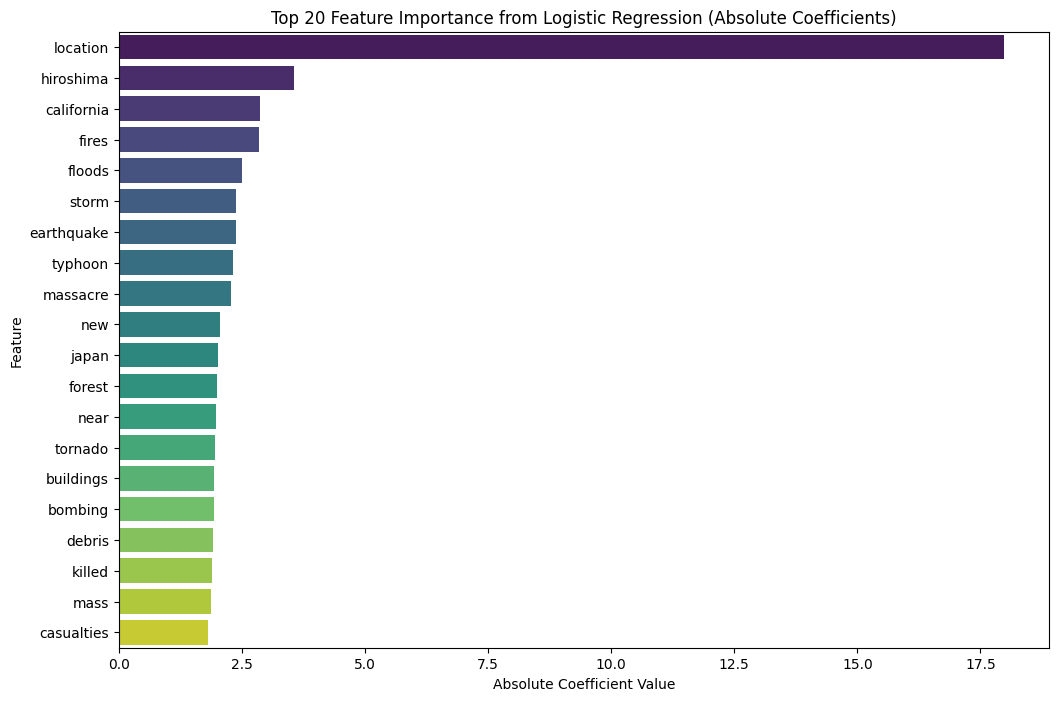

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names from X_train_final
feature_names = X_train_final.columns

# Get coefficients from the trained model
# For Logistic Regression, model.coef_ is a 2D array, so we take the first row
coefficients = model.coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': coefficients
})

# Sort by absolute importance to get the most impactful features
feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)

# Display the top 20 most important features
print("Top 20 Most Important Features:")
display(feature_importance.head(20))

# Plotting the top N features
plt.figure(figsize=(12, 8))
sns.barplot(x='Abs_Importance', y='Feature', data=feature_importance.head(20), palette='viridis')
plt.title('Top 20 Feature Importance from Logistic Regression (Absolute Coefficients)')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature')
plt.show()

Aparentemente la feature location tiene mucha importancia. Igualmente es una feature que usa meanecoding y tiene mucha variedad en una. Es decir, las demas feature se dividen en distintas feature. Por ejemplo hiroshima es parte del text y tiene mucha importancia para ser una feature de una palabra.